In [215]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import zscore

# Configurando estilos
sns.set(style="whitegrid")
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [216]:
directory = '..\\data\\processed'
parquet_file = [file for file in os.listdir(directory) if file.endswith('.parquet')][0]

In [217]:
parquet_dir = os.path.join(directory, parquet_file)
print(parquet_dir)

..\data\processed\concatenated_dfs.parquet


In [218]:
df = pd.read_parquet(parquet_dir)

# Objetivos da análise

## 1 Ver condição dos dados:
1. Nulos e faltantes - Done
1. Tipo dos dados - Done

# 1. Condição dos dados
## Nulos e faltantes

In [219]:
df.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,None,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,None,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,None,Alexander Peartree,None,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [220]:
for column in df.columns:
    nan_rows = round((df[column].isna().sum()/df.shape[0])*100,2).astype(str)+'%' # type: ignore
    print(f"Column name: {column} has {nan_rows} of NaN values")

Column name: country has 0.02% of NaN values
Column name: description has 0.0% of NaN values
Column name: designation has 29.62% of NaN values
Column name: points has 0.0% of NaN values
Column name: price has 8.08% of NaN values
Column name: province has 0.02% of NaN values
Column name: region_1 has 16.49% of NaN values
Column name: region_2 has 60.32% of NaN values
Column name: taster_name has 63.07% of NaN values
Column name: taster_twitter_handle has 64.84% of NaN values
Column name: title has 53.73% of NaN values
Column name: variety has 0.0% of NaN values
Column name: winery has 0.0% of NaN values


#### Checking data integrity
* Is there any difference between region_1 and region_2 values? - Done
* Rows with no price have at least values of variety or title for later input and treatment? - Done
* The number of taster_name that is NaN came from the 150k dataset? - Useless information, probably we won't be using at the recommendation system
* Which rows has title blank? There is any other information from there? - Done

##### Difference between region_1 and region_2

In [221]:
print(f"Region 1 has {df.region_1.nunique()} unique values")
print(f"Region 2 has {df.region_2.nunique()} unique values")

Region 1 has 1332 unique values
Region 2 has 18 unique values


In [222]:
df[~df['region_2'].isna()].shape[0]

111464

In [223]:
df.loc[(df['region_1']!= df['region_2'] ) & (df['region_2'].notnull()), ['region_1','region_2']]

,region_1,region_2
10,Napa Valley,Napa
12,Alexander Valley,Sonoma
21,Oregon,Oregon Other
23,Paso Robles,Central Coast
25,Sonoma Coast,Sonoma
...,...,...
280860,Santa Ynez Valley,Central Coast
280863,California,California Other
280867,California,California Other
280885,Anderson Valley,Mendocino/Lake Counties


It looks like the values are not the same as region_1, sice it has 100k non null values with different descriptions as region_1

##### NaN Price rows 

In [224]:
df.price.isna().sum()

22691

In [225]:
df_temp = df[df['price'].isna()]
df_temp.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
118476,France,The wine has the typical Provence rosé color—a...,None,89,NaN,Provence,Palette,None,Roger Voss,@vossroger,Château Henri Bonnaud 2013 Rosé (Palette),Rosé,Château Henri Bonnaud
63117,Italy,This is a straightforward and genuine Barolo w...,Cerretta,91,NaN,Piedmont,Barolo,None,None,None,Germano Ettore 2006 Cerretta (Barolo),Nebbiolo,Germano Ettore
256724,France,"A rich, creamy, toast- and caramel- flavored w...",Terres de Noël Blanc de Blancs Grand Cru Brut,92,NaN,Champagne,Champagne,None,None,None,None,Chardonnay,Jean Milan
109181,US,"Light in color, this wine brings aromas of pep...",The Harrison,90,NaN,Oregon,Willamette Valley,Willamette Valley,Sean P. Sullivan,@wawinereport,Marion-Field 2014 The Harrison Pinot Noir (Wil...,Pinot Noir,Marion-Field
150516,Italy,This classic Amarone offers characteristic aro...,None,89,NaN,Veneto,Amarone della Valpolicella Classico,None,None,None,None,"Corvina, Rondinella, Molinara",Manzini


In [226]:
for column in df.columns:
    nan_rows = round((df_temp[column].isna().sum()/df_temp.shape[0])*100,2).astype(str)+'%' # type: ignore
    print(f"Column name: {column} has {nan_rows} of NaN values")

Column name: country has 0.02% of NaN values
Column name: description has 0.0% of NaN values
Column name: designation has 26.93% of NaN values
Column name: points has 0.0% of NaN values
Column name: price has 100.0% of NaN values
Column name: province has 0.02% of NaN values
Column name: region_1 has 17.14% of NaN values
Column name: region_2 has 97.94% of NaN values
Column name: taster_name has 68.06% of NaN values
Column name: taster_twitter_handle has 68.27% of NaN values
Column name: title has 60.35% of NaN values
Column name: variety has 0.0% of NaN values
Column name: winery has 0.0% of NaN values


Looking for the rows that has no price, we have all of them with variety, winery and points value. In that case we could estimate the price based on [Winery, Variet, and Points values]. Its a guarantee that we can use all of the 22k rows with null prices 

##### Title NaN rows

In [227]:
df.title.isna().sum()

150930

In [228]:
df_temp = df[df['title'].isna()]
df_temp.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
265174,Argentina,Alamos takes Merlot to the next level with thi...,None,88,12.0,Mendoza Province,Mendoza,None,None,None,None,Merlot,Alamos
194023,US,Harrison Hill includes a small amount of the s...,Harrison Hill,90,45.0,Washington,Yakima Valley,Columbia Valley,None,None,None,Red Blend,DeLille
232693,Chile,"Dense, slightly foresty and typical, meaning t...",Casa la Joya Gran Reserve,88,15.0,Colchagua Valley,None,None,None,None,None,Carmenère,Viña Bisquertt
176024,Italy,Tosco Forte is an easy but penetrating wine th...,Tosco Forte,87,NaN,Tuscany,Toscana,None,None,None,None,Sangiovese,Castello di Poppiano
246282,Australia,An opening scent of freshly cut grass is follo...,Deen De Bortoli Vat 2,84,13.0,Australia Other,Australia,None,None,None,None,Sauvignon Blanc,De Bortoli


In [229]:
for column in df.columns:
    nan_rows = round((df_temp[column].isna().sum()/df_temp.shape[0])*100,2).astype(str)+'%' # type: ignore
    print(f"Column name: {column} has {nan_rows} of NaN values")

Column name: country has 0.0% of NaN values
Column name: description has 0.0% of NaN values
Column name: designation has 30.3% of NaN values
Column name: points has 0.0% of NaN values
Column name: price has 9.07% of NaN values
Column name: province has 0.0% of NaN values
Column name: region_1 has 16.6% of NaN values
Column name: region_2 has 59.62% of NaN values
Column name: taster_name has 100.0% of NaN values
Column name: taster_twitter_handle has 100.0% of NaN values
Column name: title has 100.0% of NaN values
Column name: variety has 0.0% of NaN values
Column name: winery has 0.0% of NaN values


As it has all the taster_name and twitter values NaN, we can assume that most of them came from the 150k dataset. No need for futher investigation

#


## Tipos dos dados

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280901 entries, 0 to 280900
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                280833 non-null  object 
 1   description            280901 non-null  object 
 2   designation            197701 non-null  object 
 3   points                 280901 non-null  int64  
 4   price                  258210 non-null  float64
 5   province               280833 non-null  object 
 6   region_1               234594 non-null  object 
 7   region_2               111464 non-null  object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                280900 non-null  object 
 12  winery                 280901 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 27.9+ MB


For me is okay, don't need any other treatment for now. Futher, when doing feature engineering, we'll scale, encode variables and gather information from description

## 2 Distribuição dos vinhos com relação a:
1. Pontos e Preço - TbD
1. País e região - TbD
1. Variedade - TbD
1. Winery - TbD
1. Designation - TbD
1. Avaliadores - TbD


## Pontos e preços

In [231]:
#Olhando a distribuição das duas variáveis numéricas que temos disponíveis
df.describe()

,points,price
count,280901.000000,258210.000000
mean,88.146934,34.177162
std,3.151528,38.611708
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,25.000000
75%,90.000000,40.000000
max,100.000000,3300.000000


* Valores de pontos distribuiídos entre 80 e 100, com pequena variação
* Preços possuem maior variação e uma grande diferença entre a média e valor máximo (possível incidência de outliers)

### Distribuição dos pontos

* Olhar para as distribuição dos pontos, quartis e quantidades

c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lci734\AppData\Local\Temp\ipykernel_21680\66827877.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()

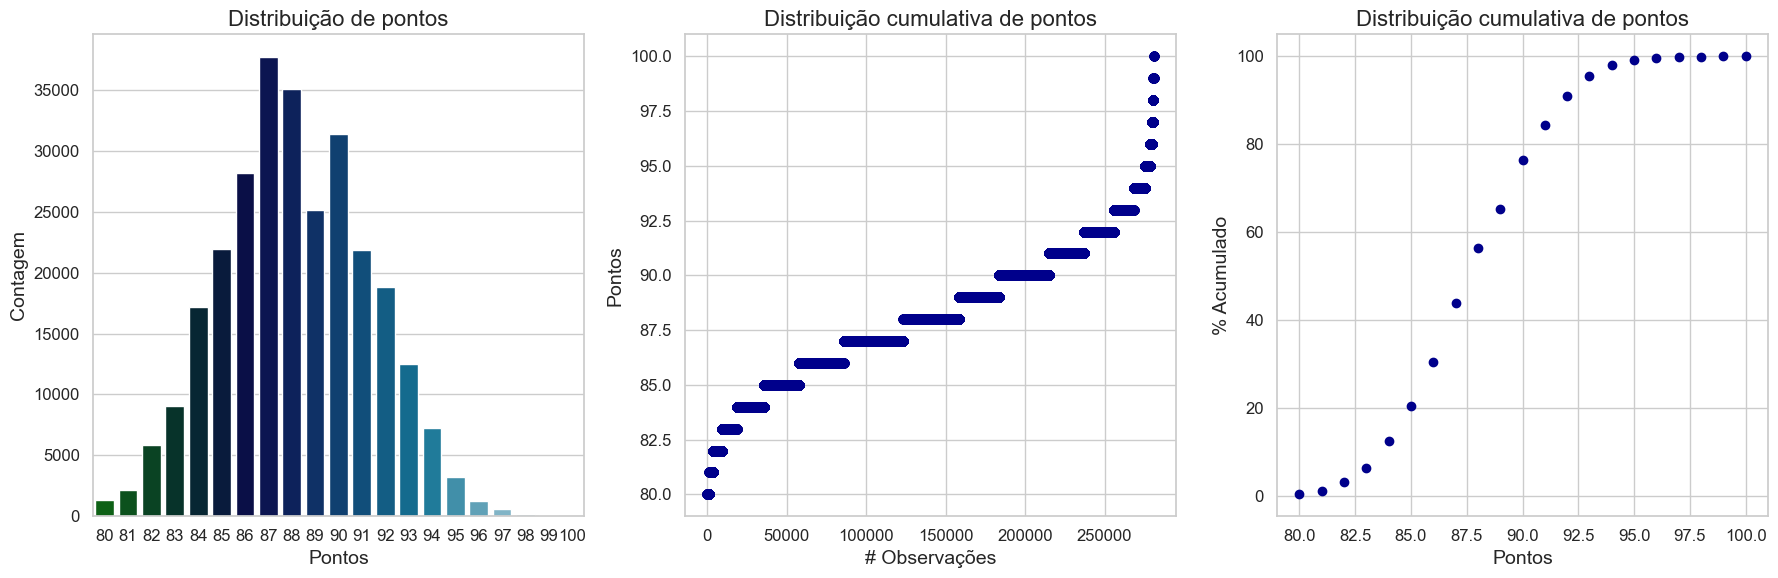

In [232]:

# Calcular a soma acumulada
cum_sum = df.groupby('points').agg(frequency = ('points', 'count')).reset_index()
total = cum_sum.frequency.sum()
cum_sum['cumulative_sum'] = round((cum_sum['frequency'].cumsum()/len(df))*100,2)


#Plotagem
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize= (18,6))

#Primeiro plot - histograma de pontos
sns.countplot(data = df, x = 'points', palette = 'ocean', ax = axes[0])
axes[0].set_title('Distribuição de pontos')
axes[0].set_xlabel('Pontos')
axes[0].set_ylabel('Contagem')
plt.tight_layout()

#Segundo plot - Preços vs nota
axes[1].scatter(data = df.sort_values(by='points', ascending=True), x = range(df.shape[0]) , y = 'points',color = 'darkblue')
axes[1].set_title('Distribuição cumulativa de pontos')
axes[1].set_xlabel('# Observações')
axes[1].set_ylabel('Pontos')

# Terceiro plot
axes[2].scatter(data = cum_sum, x = 'points', y= 'cumulative_sum', color = 'darkblue')
axes[2].set_title('Distribuição cumulativa de pontos')
axes[2].set_xlabel('Pontos')
axes[2].set_ylabel('% Acumulado')
plt.tight_layout()
plt.show()

### Variedade

* Olhar para distribuição de vinhos com maiores frequencias
* Distribuição dos vinhos mais avaliados
* Distribuição dos pontos distribuidos ao longo das variedades

In [233]:
count = df.groupby('variety').agg(count_column=('variety', 'count')).reset_index().sort_values(by = 'count_column', ascending= False)[:20]

In [234]:
count

,variety,count_column
476,Pinot Noir,27563
132,Chardonnay,26235
84,Cabernet Sauvignon,22272
510,Red Blend,19008
64,Bordeaux-style Red Blend,14262
553,Sauvignon Blanc,11287
516,Riesling,10713
604,Syrah,9967
350,Merlot,8172
751,Zinfandel,6513


c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


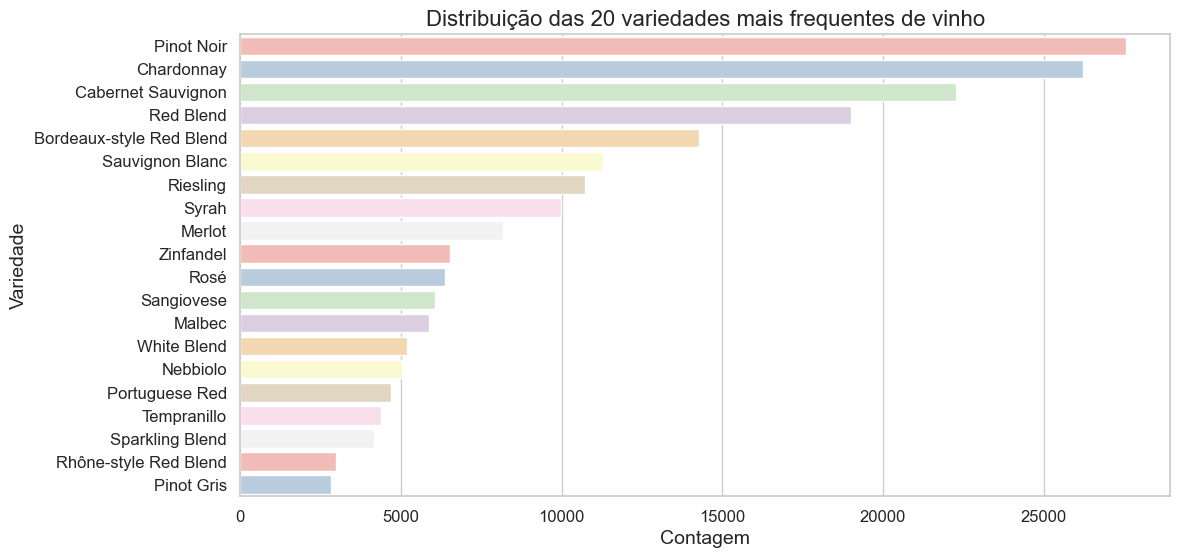

In [235]:

plt.figure(figsize=(12,6))
plt.title('Distribuição das 20 variedades mais frequentes de vinho')
sns.barplot(data = count, x = 'count_column', y = 'variety', palette = 'Pastel1', orient = 'h')
plt.xlabel('Contagem')
plt.ylabel('Variedade');


Vinho uva pinot noir é a uva mais vezes avaliada, sendo ela uma uva tinta

### País e região

##### Distribuição geral

In [236]:
regions_1 = df.groupby('region_1')['region_1'].value_counts().sort_values(ascending=False).reset_index()
regions_1['index']=regions_1.index

regions_2 = df.groupby('region_2')['region_2'].value_counts().sort_values(ascending=False).reset_index()
regions_2['index']=regions_2.index

In [237]:
print('region_1', '\n', regions_1.describe())
print('region_2', '\n', regions_2.describe())

region_1 
               count       index
count   1332.000000  1332.00000
mean     176.121622   665.50000
std      635.988250   384.65959
min        1.000000     0.00000
25%        5.000000   332.75000
50%       22.000000   665.50000
75%       99.000000   998.25000
max    10689.000000  1331.00000
region_2 
               count      index
count     18.000000  18.000000
mean    6192.444444   8.500000
std     7574.108328   5.338539
min      378.000000   0.000000
25%     1403.750000   4.250000
50%     2601.500000   8.500000
75%     6497.750000  12.750000
max    24122.000000  17.000000


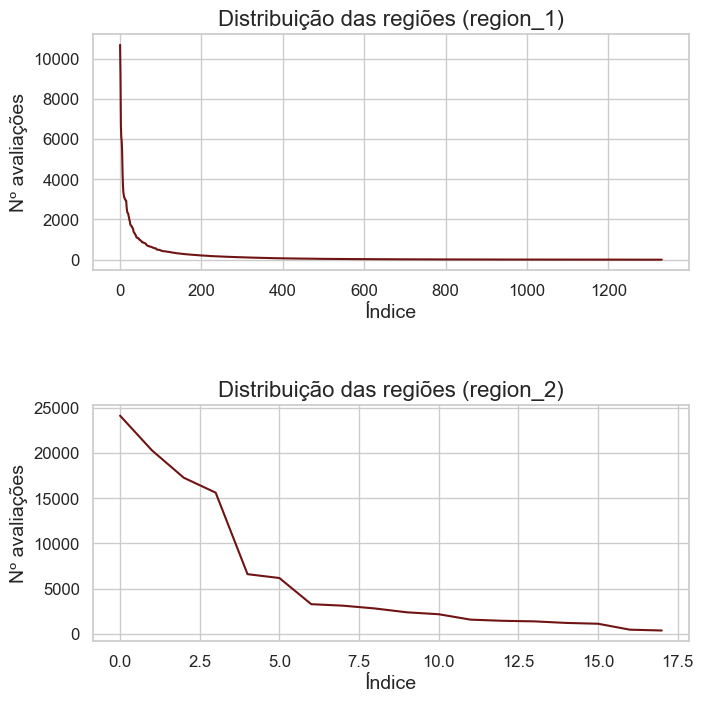

In [238]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8))

x1 = regions_1.index.values
y1 = regions_1['count'].values

x2 = regions_2.index.values
y2 = regions_2['count'].values

ax[0].plot(x1, y1, c='#701313')
ax[1].plot(x2, y2, c='#701313')

for i in range(0,2):
    ax[i].set_title(f'Distribuição das regiões (region_{i+1})')
    ax[i].set_xlabel('Índice')

    ax[i].set_ylabel('Nº avaliações')

fig.tight_layout(pad=3)

plt.show()

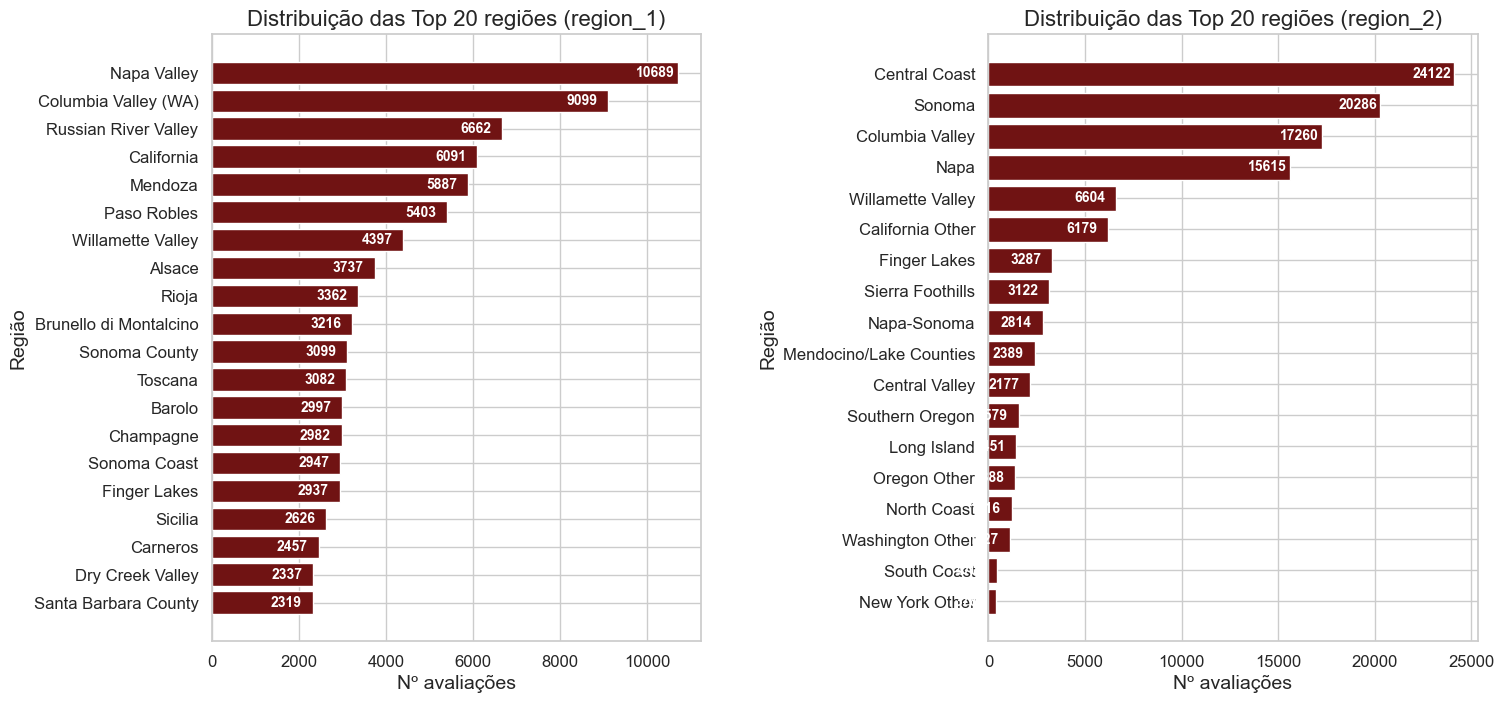

In [239]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

def labels(array, ax):
    for i, value in enumerate(array):
        ax[ax].set_text(s=value, x=array[i], y=i)

x1 = regions_1['count'].values[0:20]
y1 = regions_1['region_1'].values[0:20]

x2 = regions_2['count'].values[0:20]
y2 = regions_2['region_2'].values[0:20]

bars1 = ax[0].barh(y1, x1, color='#701313')
bars2 = ax[1].barh(y2, x2, color='#701313')

for i in range(0,2):
    ax[i].set_title(f'Distribuição das Top 20 regiões (region_{i+1})')
    ax[i].set_ylabel('Região')
    ax[i].set_xlabel('Nº avaliações')
    ax[i].invert_yaxis()    

fig.tight_layout(pad=3)

ax[0].bar_label(bars1 , x1, padding=-30, fontsize=10, color='white', fontweight='bold', label_type='edge')
ax[1].bar_label(bars2 , x2, padding=-30, fontsize=10, color='white', fontweight='bold', label_type='edge')

plt.show()

##### Verificando se a distribuição das regiões segue uma distribuição normal

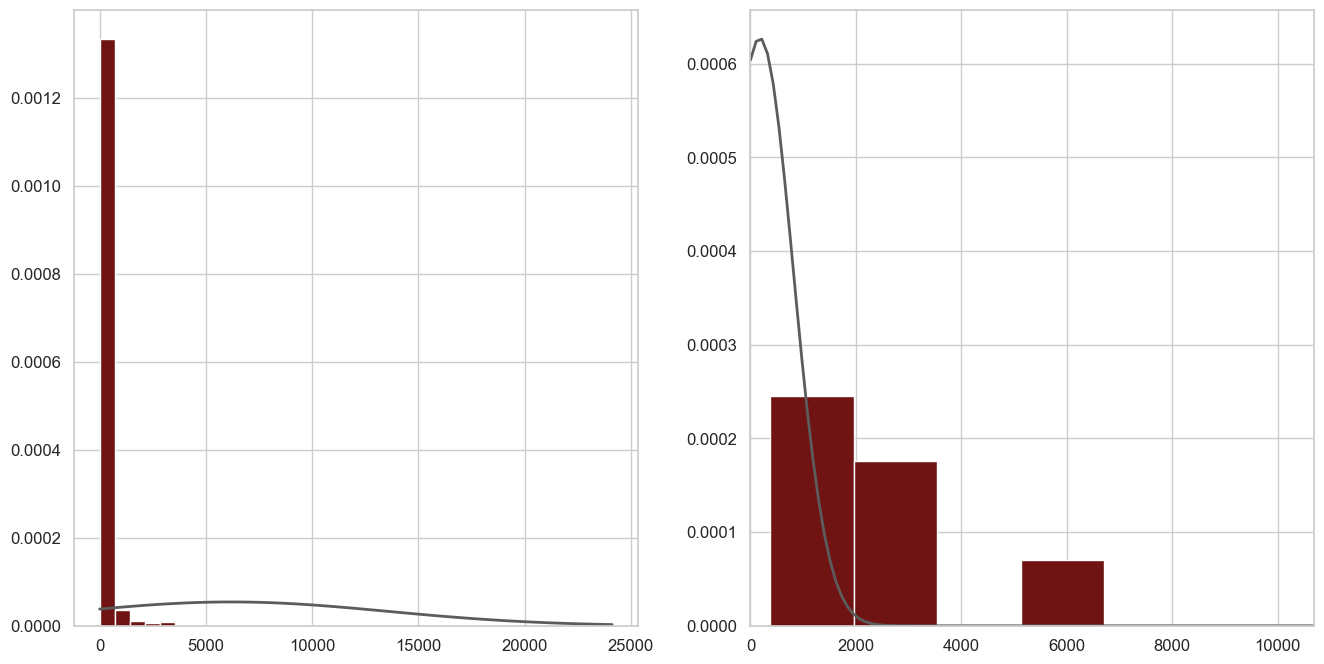

In [240]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

x1 = regions_1['count'].values
x2 = regions_2['count'].values

# Plotting histogram
ax[0].hist(x1, bins=15, color='#701313', density=True)
ax[1].hist(x2, bins=15, color='#701313', density=True)

# Removing outliers
z_scores = np.abs(zscore(regions_1['count']))
threshold = 3
regions = regions_1[z_scores <= threshold]
x2 = regions_1['count'].values

# Removing outliers
z_scores = np.abs(zscore(regions_2['count']))
threshold = 3
regions = regions_2[z_scores <= threshold]
x1 = regions_2['count'].values

# Normal distribuition params
mean, std = norm.fit(x1)
xmin = 0
xmax = x1.max()
plt.xlim(xmin, xmax)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
# Plotting normal distribuition
ax.flat[0].plot(x, p, color='#5C5C5C', linewidth=2)

# Normal distribuition params
mean, std = norm.fit(x2)
xmin = 0
xmax = x2.max()
plt.xlim(xmin, xmax)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
# Plotting normal distribuition
ax.flat[1].plot(x, p, color='#5C5C5C', linewidth=2)
plt.show()

###